In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
print(f"CUDA Available: {torch.cuda.is_available()}")

CUDA Available: True


In [3]:
# Load the dataset (in CSV format with 'Text' and 'Summary' columns)
df = pd.read_csv('Reviews_q2_main.csv')
df['Text'] = df['Text'].astype(str)
df['Summary'] = df['Summary'].astype(str)
df['Text'].fillna('', inplace=True)
df['Summary'].fillna('', inplace=True)

C:\Users\Yusuf\AppData\Local\Temp\ipykernel_3076\2764011218.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Text'].fillna('', inplace=True)
C:\Users\Yusuf\AppData\Local\Temp\ipykernel_3076\2764011218.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doin

In [4]:
# Tokenize text
def tokenize(text):
    return word_tokenize(text.lower())

# Build vocabulary
def build_vocab(tokenized_texts, max_vocab_size=10000):
    all_tokens = [token for text in tokenized_texts for token in text]
    most_common = Counter(all_tokens).most_common(max_vocab_size - 4)  # Reserve space for special tokens
    word_to_idx = {word: idx + 4 for idx, (word, _) in enumerate(most_common)}
    word_to_idx['<pad>'] = 0
    word_to_idx['<unk>'] = 1
    word_to_idx['<sos>'] = 2
    word_to_idx['<eos>'] = 3
    return word_to_idx

# Add special tokens to the tokenized summaries
def add_special_tokens(tokenized_texts, vocab):
    return [['<sos>'] + text + ['<eos>'] for text in tokenized_texts]

In [5]:
# Tokenize and build vocabulary for reviews and summaries
tokenized_reviews = [tokenize(text) for text in df['Text'].values]
tokenized_summaries = [tokenize(summary) for summary in df['Summary'].values]
review_vocab = build_vocab(tokenized_reviews)
summary_vocab = build_vocab(tokenized_summaries)

# Add special tokens to the tokenized summaries
tokenized_summaries = add_special_tokens(tokenized_summaries, summary_vocab)

In [6]:
# Convert tokens to indices
def tokens_to_indices(tokenized_texts, vocab):
    return [[vocab.get(token, vocab['<unk>']) for token in text] for text in tokenized_texts]

indexed_reviews = tokens_to_indices(tokenized_reviews, review_vocab)
indexed_summaries = tokens_to_indices(tokenized_summaries, summary_vocab)

In [7]:
# Limit sequence lengths
MAX_REVIEW_LEN = 100
MAX_SUMMARY_LEN = 30

def pad_sequences(sequences, pad_idx, max_len=None):
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)
    return [seq[:max_len] + [pad_idx] * (max_len - len(seq[:max_len])) for seq in sequences]

# Pad and truncate sequences
padded_reviews = pad_sequences(indexed_reviews, review_vocab['<pad>'], MAX_REVIEW_LEN)
padded_summaries = pad_sequences(indexed_summaries, summary_vocab['<pad>'], MAX_SUMMARY_LEN)

In [8]:
# Split the dataset into training, validation, and test sets with an 80-15-5 ratio
train_data, temp_data, y_train, y_temp = train_test_split(
    padded_reviews, padded_summaries, test_size=0.2, random_state=42
)
val_data, test_data, y_val, y_test = train_test_split(
    temp_data, y_temp, test_size=0.25, random_state=42
)

# Convert these splits into tensors
X_train = torch.tensor(train_data, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(val_data, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(test_data, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [9]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Add this function to load GloVe embeddings and build the embedding matrix
def load_glove_embeddings(glove_file_path, embedding_dim, vocab):
    """
    Load GloVe embeddings and create an embedding matrix for the given vocabulary.
    """
    embeddings = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector

    # Create an embedding matrix for the vocabulary
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        if word in embeddings:
            embedding_matrix[idx] = embeddings[word]
        else:
            # Assign a random normal vector if the word is not found in the GloVe vectors
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return torch.tensor(embedding_matrix, dtype=torch.float32)

In [11]:
# Define the file path and embedding dimension
glove_file_path = 'glove.6B.100d.txt'  
embedding_dim = 100

# Load GloVe embeddings for review and summary vocabularies
review_embedding_matrix = load_glove_embeddings(glove_file_path, embedding_dim, review_vocab)
summary_embedding_matrix = load_glove_embeddings(glove_file_path, embedding_dim, summary_vocab)

In [12]:
# encoder with GloVe embeddings
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, review_embedding_matrix):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(review_embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc_hidden = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_cell = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        hidden = torch.tanh(self.fc_hidden(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)))
        cell = torch.tanh(self.fc_cell(torch.cat((cell[-2, :, :], cell[-1, :, :]), dim=1)))
        return outputs, hidden.unsqueeze(0), cell.unsqueeze(0)

In [13]:
# decoder with GloVe embeddings
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, summary_embedding_matrix):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(summary_embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, trg, hidden, cell):
        embedded = self.embedding(trg.unsqueeze(1))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

In [14]:
# Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.6):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(src.device)

        encoder_outputs, hidden, cell = self.encoder(src)

        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output
            top1 = output.argmax(1)
            input = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs

In [15]:
def calculate_token_accuracy(predictions, targets, pad_idx):
    """Calculates token-level accuracy."""
    # Flatten both predictions and targets, and remove padding indices
    predictions_flat = predictions.view(-1)
    targets_flat = targets.view(-1)
    
    # Ignore the padding token
    mask = targets_flat != pad_idx
    correct_predictions = predictions_flat[mask] == targets_flat[mask]
    
    # Calculate accuracy
    accuracy = correct_predictions.sum().item() / mask.sum().item()
    return accuracy


In [16]:
def beam_search_decode(model, tensor, vocab, max_len=30, beam_width=5, device='cpu'):
    model.eval()
    
    with torch.no_grad():
        # Encode the input review
        _, hidden, cell = model.encoder(tensor)
        
        # Initialize the beams with the start-of-sequence token
        beams = [(torch.tensor([vocab['<sos>']], device=device), hidden, cell, 0.0)]
        
        for _ in range(max_len):
            new_beams = []
            for seq, hidden, cell, score in beams:
                last_token = seq[-1].unsqueeze(0)
                if last_token.item() == vocab['<eos>']:
                    new_beams.append((seq, hidden, cell, score))
                    continue

                output, hidden, cell = model.decoder(last_token, hidden, cell)
                probs = torch.softmax(output, dim=1)
                top_k_probs, top_k_indices = probs.topk(beam_width)

                for i in range(beam_width):
                    new_seq = torch.cat([seq, top_k_indices[:, i]])
                    new_score = score + torch.log(top_k_probs[0][i]).item()
                    new_beams.append((new_seq, hidden, cell, new_score))

            beams = sorted(new_beams, key=lambda x: x[3], reverse=True)[:beam_width]

        best_beam = max(beams, key=lambda x: x[3])
        best_seq = best_beam[0].tolist()

    summary_tokens = [list(vocab.keys())[list(vocab.values()).index(idx)] for idx in best_seq[1:]]
    return ' '.join(summary_tokens)

In [17]:
def train_epoch_with_accuracy(model, iterator, optimizer, criterion, clip, pad_idx):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0

    for i in range(0, len(iterator[0]), BATCH_SIZE):
        data_batch = iterator[0][i:i + BATCH_SIZE].to(device)
        target_batch = iterator[1][i:i + BATCH_SIZE].to(device)

        optimizer.zero_grad()
        output = model(data_batch, target_batch, 0.6)
        output = output[:, 1:].reshape(-1, output.shape[-1])
        target_batch = target_batch[:, 1:].reshape(-1)

        loss = criterion(output, target_batch)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate token-level accuracy
        predictions = output.argmax(1).reshape(-1)
        epoch_accuracy += calculate_token_accuracy(predictions, target_batch, pad_idx)

    # Calculate average loss and accuracy
    avg_loss = epoch_loss / len(iterator[0])
    avg_accuracy = epoch_accuracy / (len(iterator[0]) // BATCH_SIZE)

    return avg_loss, avg_accuracy


In [18]:
def evaluate_epoch_with_accuracy(model, iterator, criterion, pad_idx):
    model.eval()
    epoch_loss = 0
    epoch_accuracy = 0

    with torch.no_grad():
        for i in range(0, len(iterator[0]), BATCH_SIZE):
            data_batch = iterator[0][i:i + BATCH_SIZE].to(device)
            target_batch = iterator[1][i:i + BATCH_SIZE].to(device)

            output = model(data_batch, target_batch, 0)
            output = output[:, 1:].reshape(-1, output.shape[-1])
            target_batch = target_batch[:, 1:].reshape(-1)

            loss = criterion(output, target_batch)
            epoch_loss += loss.item()

            predictions = output.argmax(1).reshape(-1)
            epoch_accuracy += calculate_token_accuracy(predictions, target_batch, pad_idx)

    # Calculate average loss and accuracy
    avg_loss = epoch_loss / len(iterator[0])
    avg_accuracy = epoch_accuracy / (len(iterator[0]) // BATCH_SIZE)
    
    return avg_loss, avg_accuracy


In [19]:
# Set hyperparameters and initialize model
INPUT_DIM = len(review_vocab)
OUTPUT_DIM = len(summary_vocab)
EMB_DIM = 100
HID_DIM = 256
N_EPOCHS = 50
LEARNING_RATE = 0.001
CLIP = 1
BATCH_SIZE = 32

In [20]:
encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, review_embedding_matrix).to(device)
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, summary_embedding_matrix).to(device)
model = Seq2Seq(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=review_vocab['<pad>'])
best_valid_loss = float('inf')

In [21]:
train_losses = []
val_losses = []

for epoch in range(N_EPOCHS):
    train_loss, train_accuracy = train_epoch_with_accuracy(model, (X_train, y_train), optimizer, criterion, CLIP, review_vocab['<pad>'])
    valid_loss, valid_accuracy = evaluate_epoch_with_accuracy(model, (X_val, y_val), criterion, review_vocab['<pad>'])

    train_losses.append(train_loss)
    val_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lstm_lstm.pth')

    print(f'Epoch: {epoch + 1}')
    print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy:.3f} | Validation Loss: {valid_loss:.3f} | Validation Accuracy: {valid_accuracy:.3f}')

# Evaluate on the test set after training 
test_loss, test_accuracy = evaluate_epoch_with_accuracy(model, (X_test, y_test), criterion, review_vocab['<pad>'])
print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_accuracy:.3f}')


Epoch: 1
Train Loss: 0.175 | Train Accuracy: 0.194 | Validation Loss: 0.179 | Validation Accuracy: 0.194
Epoch: 2
Train Loss: 0.161 | Train Accuracy: 0.210 | Validation Loss: 0.181 | Validation Accuracy: 0.194
Epoch: 3
Train Loss: 0.154 | Train Accuracy: 0.219 | Validation Loss: 0.182 | Validation Accuracy: 0.194
Epoch: 4
Train Loss: 0.150 | Train Accuracy: 0.224 | Validation Loss: 0.182 | Validation Accuracy: 0.194
Epoch: 5
Train Loss: 0.146 | Train Accuracy: 0.229 | Validation Loss: 0.184 | Validation Accuracy: 0.194
Epoch: 6
Train Loss: 0.143 | Train Accuracy: 0.235 | Validation Loss: 0.185 | Validation Accuracy: 0.194
Epoch: 7
Train Loss: 0.140 | Train Accuracy: 0.239 | Validation Loss: 0.187 | Validation Accuracy: 0.194
Epoch: 8
Train Loss: 0.138 | Train Accuracy: 0.243 | Validation Loss: 0.187 | Validation Accuracy: 0.194
Epoch: 9
Train Loss: 0.135 | Train Accuracy: 0.249 | Validation Loss: 0.187 | Validation Accuracy: 0.194
Epoch: 10
Train Loss: 0.132 | Train Accuracy: 0.256 | V

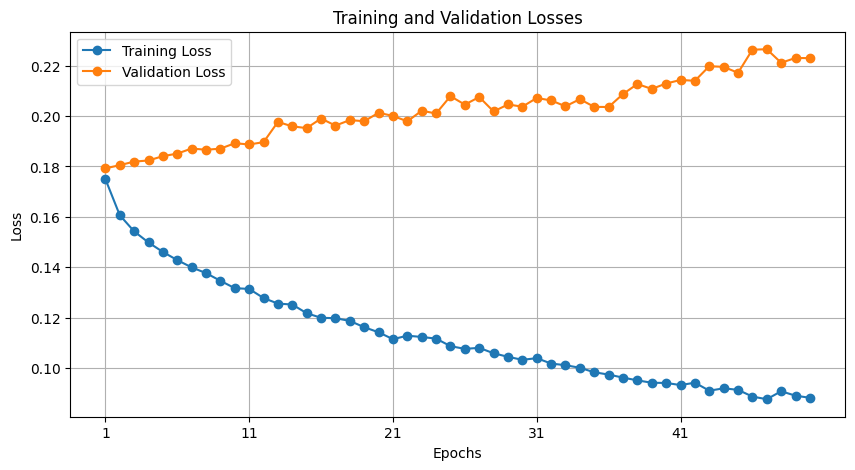

In [22]:
import matplotlib.pyplot as plt

# Number of epochs
epochs = range(1, len(train_losses) + 1)

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

# Add title and labels
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(epochs), 10))  # Set x-ticks to be the epoch numbers
plt.legend()  # Show legend
plt.grid()  # Add grid for better readability

# Show the plot
plt.show()

In [23]:
import evaluate

# Define evaluation functions for BLEU and CHRF scores
bleu = evaluate.load("bleu")
chrf = evaluate.load("chrf")

def evaluate_test_set(model, test_data, test_targets, vocab, device='cpu', max_len=30, beam_width=5):
    model.eval()
    all_results = []

    with torch.no_grad():
        for i in range(0, len(test_data), BATCH_SIZE):
            data_batch = test_data[i:i + BATCH_SIZE].to(device)
            target_batch = test_targets[i:i + BATCH_SIZE]

            for j, review in enumerate(data_batch):
                tokens = review.tolist()
                indexed = [tok for tok in tokens if tok != vocab['<pad>']]
                tensor = torch.tensor(indexed).unsqueeze(0).to(device)
                predicted_summary = beam_search_decode(model, tensor, vocab, max_len, beam_width, device)

                actual_tokens = target_batch[j].tolist()
                actual_indexed = [tok for tok in actual_tokens if tok != vocab['<pad>']]
                actual_summary = ' '.join([list(vocab.keys())[list(vocab.values()).index(idx)]
                                           if idx in vocab.values() else '<unk>' for idx in actual_indexed[1:-1]])

                bleu_score = bleu.compute(predictions=[predicted_summary], references=[[actual_summary]])
                chrf_score = chrf.compute(predictions=[predicted_summary], references=[[actual_summary]])

                all_results.append({
                    "Review": ' '.join([list(vocab.keys())[list(vocab.values()).index(idx)]
                                        if idx in vocab.values() else '<unk>' for idx in indexed]),
                    "Actual Summary": actual_summary,
                    "Predicted Summary": predicted_summary,
                    "BLEU Score": bleu_score['bleu'],
                    "CHRF Score": chrf_score['score']
                })

    return all_results


e:\ANACONDA3\ENVS\PY3918\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
# Load the state dictionary (weights) into the model
model.load_state_dict(torch.load('lstm_lstm.pth'))
model.eval()

C:\Users\Yusuf\AppData\Local\Temp\ipykernel_3076\1587450691.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstm_lstm.pth'))


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 100)
    (lstm): LSTM(100, 256, batch_first=True, bidirectional=True)
    (fc_hidden): Linear(in_features=512, out_features=256, bias=True)
    (fc_cell): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(8798, 100)
    (lstm): LSTM(100, 256, batch_first=True)
    (fc_out): Linear(in_features=256, out_features=8798, bias=True)
  )
)

In [25]:
# Evaluate the model on the test set
test_results = evaluate_test_set(model, X_test, y_test, summary_vocab, device, max_len=30, beam_width=5)

# Create a DataFrame from the results
test_results_df = pd.DataFrame(test_results, columns=["Review", "Actual Summary", "Predicted Summary", "BLEU Score", "CHRF Score"])

# Save the DataFrame to a CSV file
test_results_df.to_csv('lstm_lstm_results.csv', index=False)

print("Test set results saved to 'lstm_lstm_results.csv'.")


Test set results saved to 'the_final_one.csv'.
